In [1]:
import os
import sys  
import pandas as pd
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.interpolate import Rbf
import numpy as np
from EpiModel import *
%load_ext autoreload

In [2]:
steps = 40
train_data = pd.read_csv('covid19-global-forecasting-week-4/train.csv')
time_index = pd.DataFrame(pd.date_range('2020-01-22', periods=83, freq='D'), columns=['Date'])
future_time_index = pd.DataFrame(pd.date_range(time_index['Date'].iloc[-1], periods=steps, freq='D')[1:], columns=['Date'])

In [3]:
country_mapping = pd.read_csv('WorldPopulation/train_country_list_mapping.csv')

In [4]:
train_data = pd.merge(train_data, country_mapping, left_on = 'Country_Region', right_on= 'Country_Region_IN_Train', how = 'left')

In [5]:
assert max(train_data.groupby(['Country_Region', 'Province_State'])['Date'].nunique()) == min(train_data.groupby(['Country_Region', 'Province_State'])['Date'].nunique())   

(<matplotlib.axes._subplots.AxesSubplot at 0x13c4624b8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13c4635c668>)

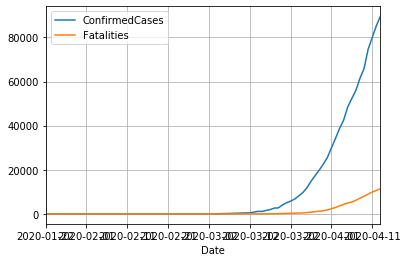

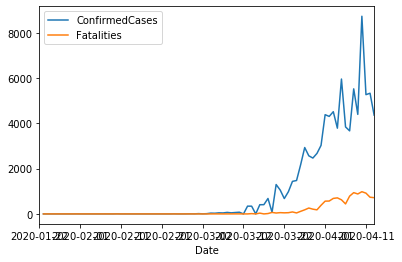

In [6]:
Country = 'United Kingdom'
df_c = train_data[train_data['Country_Region'] == Country][['Date','Province_State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x13c25155be0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13c46850b38>)

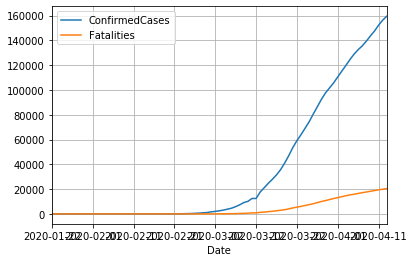

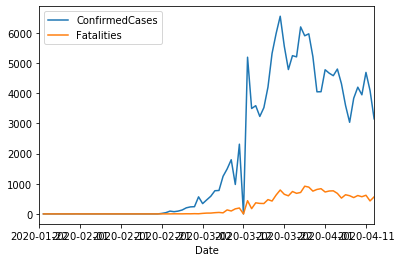

In [7]:
Country = 'Italy'
df_c = train_data[train_data['Country_Region'] == Country][['Date','Province_State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.plot()

In [8]:
population_data = pd.read_csv('WorldPopulation/AllEntityPopulations.csv')

In [9]:
train_data['Entity']=train_data['Province_State']

In [10]:
train_data.loc[train_data['Entity'].isna(),'Entity']  = train_data.loc[train_data['Province_State'].isna(),'Country_Region']

In [11]:
train_data = pd.merge(train_data, population_data, left_on = 'Entity', right_on = 'entity').fillna(0)

In [12]:
train_data.nunique()

Id                         25398
Province_State               131
Country_Region               180
Date                          83
ConfirmedCases              2695
Fatalities                   695
Country_Region_IN_Train      180
Altername                    175
2                            174
ISO                          175
Entity                       305
entity                       305
population                   301
region                         6
subregion                     23
dtype: int64

In [13]:
train_data[train_data['Country_Region']=='United Kingdom']

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Country_Region_IN_Train,Altername,2,ISO,Entity,entity,population,region,subregion
23987,33517,Anguilla,United Kingdom,2020-01-22,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23988,33518,Anguilla,United Kingdom,2020-01-23,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23989,33519,Anguilla,United Kingdom,2020-01-24,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23990,33520,Anguilla,United Kingdom,2020-01-25,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23991,33521,Anguilla,United Kingdom,2020-01-26,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23992,33522,Anguilla,United Kingdom,2020-01-27,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23993,33523,Anguilla,United Kingdom,2020-01-28,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23994,33524,Anguilla,United Kingdom,2020-01-29,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23995,33525,Anguilla,United Kingdom,2020-01-30,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean
23996,33526,Anguilla,United Kingdom,2020-01-31,0.0,0.0,United Kingdom,United Kingdom,GB,GBR,Anguilla,Anguilla,13452,Americas,Caribbean


In [14]:
Possible_R0 = np.linspace(0.2,0.296,10)
Possible_lockdown = np.linspace(1,4,10)
Possible_start_date = ['2020-02-19','2020-02-21','2020-02-22','2020-02-23','2020-02-24','2020-02-25','2020-02-26','2020-02-27']
#Possible_lockdown_day = np.linspace(26,34,8)
print(pd.DataFrame(pd.date_range('2020-02-27', periods=26, freq='D'), columns=['Date']).iloc[-1])
import itertools
s = [list(Possible_R0), list(Possible_lockdown),Possible_start_date]
grid_search_list = list(itertools.product(*s))
len(grid_search_list)

Date   2020-03-23
Name: 25, dtype: datetime64[ns]


800

In [15]:
lock_down_dates = pd.read_csv("20200409-acaps-covid-19-goverment-measures-dataset-clean.csv")
lock_down_dates['DATE_IMPLEMENTED'] = pd.to_datetime(lock_down_dates['DATE_IMPLEMENTED'],format = '%d/%m/%Y')

In [16]:
lockdown_country = pd.DataFrame(lock_down_dates[lock_down_dates['MEASURE'].str.contains('lockdown')].groupby(['COUNTRY','ISO','MEASURE'])['DATE_IMPLEMENTED'].max(), columns=['DATE_IMPLEMENTED']).reset_index()
lockdown_country['DATE_IMPLEMENTED'] = pd.to_datetime(lockdown_country['DATE_IMPLEMENTED'],format = '%d/%m/%Y')

In [17]:
train_data['Date'] = pd.to_datetime(train_data['Date'], format = '%Y-%m-%d' )

In [18]:
train_data = pd.merge(train_data, lockdown_country, left_on=['ISO','Date'], right_on=['ISO','DATE_IMPLEMENTED'], how='left')

In [19]:
train_data.groupby('Country_Region')['DATE_IMPLEMENTED'].count()

Country_Region
Afghanistan                1
Albania                    1
Algeria                    1
Andorra                    0
Angola                     0
Antigua and Barbuda        0
Argentina                  1
Armenia                    1
Australia                  8
Austria                    1
Azerbaijan                 0
Bahamas                    0
Bahrain                    0
Bangladesh                 0
Barbados                   0
Belarus                    0
Belgium                    1
Belize                     0
Benin                      1
Bhutan                     0
Bolivia                    1
Bosnia and Herzegovina     0
Botswana                   1
Brazil                     0
Brunei                     1
Bulgaria                   1
Burkina Faso               0
Burma                      0
Burundi                    0
Cabo Verde                 0
                          ..
Slovenia                   1
Somalia                    0
South Africa               1

In [20]:
def Simulate(beta,mu, quarantine_day, lockdown_effectiveness, N, I0):
    lockdown_toeffect = 25
    SIR = EpiModel()
    SIR.add_interaction('S', 'I', 'I', beta)
    SIR.add_spontaneous('I', 'R', mu)
    SIR.integrate(365, S=N-I0, I=I0, R=0)

    SIR2 = EpiModel()
    SIR2.add_interaction('S', 'I', 'I', beta)
    SIR2.add_spontaneous('I', 'R', mu)

    SIR2.integrate(quarantine_day+lockdown_toeffect, S=N-I0, I=I0, R=0)
    #print(quarantine_day+lockdown_toeffect)
    population = SIR2.values_.iloc[-1]
    S0 = population.S
    I0 = population.I
    R0 = population.R   

    values2 = SIR2.values_

    i=0
    for item in np.linspace(1,lockdown_effectiveness,14):

        population = values2.iloc[-1]
        S0 = population.S
        I0 = population.I
        R0 = population.R  

        beta2 = beta/item # Reduce R0 by 2.    

        Quarantine2 = EpiModel()
        Quarantine2.add_interaction('S', 'I', 'I', beta2)
        Quarantine2.add_spontaneous('I', 'R', mu)

        Quarantine2.integrate(365-quarantine_day-lockdown_toeffect-1, S=S0, I=I0, R=R0)
        if i == 13:
            values2 = pd.concat([values2, Quarantine2.values_[1:]], axis=0, ignore_index=True)
        else:    
            values2 = pd.concat([values2, Quarantine2.values_[1:2]], axis=0, ignore_index=True)
        i = i+1   
    

    population = values2.iloc[quarantine_day+lockdown_toeffect+14]
    S0 = population.S
    I0 = population.I
    R0 = population.R


    SIR2.integrate(365-quarantine_day-1+lockdown_toeffect-14, S=S0, I=I0, R=R0)

    values3 = values2.iloc[:(quarantine_day+lockdown_toeffect)].copy()
    values3 = pd.concat([values3, SIR2.values_], axis=0, ignore_index=True)
    return values2

In [21]:
from datetime import datetime
date_format = "%Y-%m-%d"
final_time_index = pd.DataFrame(pd.date_range('2020-03-26', periods=43, freq='D'), columns=['Date'])
country_lockdown = {'UK':['2020-03-23',1.5],'Italy':['2020-03-09',1.5], 'China':['2020-01-23',3], 'Spain':['2020-03-14',1.5]}
def return_result(Country_Region,real_data, population):    
    beta = 0.252
    N = population
    I0 = 1
    quarantine_day = 28
    mu=0.1
    score_list = []
    
    try:
        uk_lockdown_date = datetime.strptime(country_lockdown.get(Country_Region)[0], date_format)    
    except:
        uk_lockdown_date = datetime.strptime('2020-04-01', date_format)
    for item in grid_search_list:
        R0= item[0]
        lockdown = item[1]
        start_date = item[2]
        lockday = abs((uk_lockdown_date - datetime.strptime(start_date, date_format)).days+1)
        #true_case_portion = item[2]
        result = Simulate(R0,mu,lockday,lockdown,N,I0)
        result['Date'] = pd.DataFrame(pd.date_range(start_date, periods=365, freq='D'), columns=['Date'])
        tt = pd.merge(result, real_data, left_on = 'Date', right_on ='Date', how= 'left')
        tt['Difference_severe&critical'] = abs(tt['all_cases_by_severe&critical'] - tt['I'])
        tt['Difference_critical'] = abs(tt['all_cases_by_critical'] - tt['I'])
        tt['Difference_3'] = abs(tt['cc'] - tt['I'])
        score_severe_critical= sum(tt['Difference_severe&critical'].fillna(0))/tt['Difference_severe&critical'].count()
        score_critical = sum(tt['Difference_critical'].fillna(0))/tt['Difference_critical'].count()
        score_normal = sum(tt['Difference_3'].fillna(0))/tt['Difference_3'].count()
        score_list.append([R0,lockdown,score_severe_critical,score_critical,score_normal,start_date,lockday])
    parameter = min(score_list, key=lambda item: item[4])
    return parameter
    """ R0= parameter[0]    
    try: 
        lockdown = country_lockdown.get(Country_Region)[1]#parameter[1]
    except:
        lockdown = 2#parameter[1]
    start_date = parameter[5]
    lockday = abs((uk_lockdown_date - datetime.strptime(start_date, date_format)).days+1)
    print(start_date,pd.DataFrame(pd.date_range(start_date, periods=int(lockday), freq='D'), columns=['Date']).iloc[-1],lockday)
    resulttt = Simulate(R0,mu,lockday,lockdown,N,I0)
    resulttt['Date'] = pd.DataFrame(pd.date_range(start_date, periods=365, freq='D'), columns=['Date'])
    tt = pd.merge(resulttt, real_data, left_on = 'Date', right_on ='Date', how= 'left')
    tt['Difference_severe&critical'] = abs(tt['all_cases_by_severe&critical'] - tt['I'])
    tt['Difference_critical'] = abs(tt['all_cases_by_critical'] - tt['I'])
    tt['Difference_3'] = abs(tt['cc'] - tt['I'])
    ##print(sum(tt['Difference_3'].fillna(0)))
    tt['Day_Cases_Cum'] = tt['I']*0.185
    tt['Day_Cases'] = tt['Day_Cases_Cum'].diff(1)
    final_result = pd.merge(final_time_index, tt, left_on = 'Date', right_on ='Date', how= 'left')
    return final_result['I'] """

In [22]:
for province in train_data.fillna(0)[train_data.fillna(0)['Country_Region'] == 'United Kingdom']['Province_State'].unique():
    print(train_data.fillna(0)[(train_data.fillna(0)['Country_Region'] == 'United Kingdom')&(train_data.fillna(0)['Province_State']== province)])

         0                 0   
24728  Americas  Caribbean               0                 0   
24729  Americas  Caribbean               0                 0   
24730  Americas  Caribbean               0                 0   
24731  Americas  Caribbean               0                 0   
24732  Americas  Caribbean               0                 0   
24733  Americas  Caribbean               0                 0   
24734  Americas  Caribbean               0                 0   

          DATE_IMPLEMENTED  
24652                    0  
24653                    0  
24654                    0  
24655                    0  
24656                    0  
24657                    0  
24658                    0  
24659                    0  
24660                    0  
24661                    0  
24662                    0  
24663                    0  
24664                    0  
24665                    0  
24666                    0  
24667                    0  
24668                    0

In [23]:
Country = 'China'
state = 'Anhui'
df_c = train_data[(train_data['Country_Region'] == Country)&(train_data['Province_State'] == state)][['Date','Province_State','ConfirmedCases','Fatalities','population']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
real_data = df_acumed_daycases
real_data['all_cases_by_severe&critical'] = real_data['ConfirmedCases']/0.185
real_data['all_cases_by_critical'] = real_data['ConfirmedCases']/0.047
real_data = real_data.reset_index()
real_data['Date'] = pd.to_datetime(real_data['Date'], format='%Y-%m-%d')
real_data['cc'] = real_data['ConfirmedCases']
population = df_c['population'].max()
#return_result(Country,real_data,population)

In [24]:

beta=0.2533
mu=0.1
N= population
I0=1
SIR2 = EpiModel()
SIR2.add_interaction('S', 'I', 'I', beta)
SIR2.add_spontaneous('I', 'R', mu)
SIR2.integrate(1+25, S=N-I0, I=I0, R=0)

In [25]:
def predict_n_steps_AR(data, n_steps, use_new_model = True,maxlag=3):
    data_history = data
    if n_steps < 5:
        for i in range(n_steps):
            model = AR(data_history)
            model_fit = model.fit(maxlag=maxlag, disp=True)
            yhat = model_fit.predict(len(data_history), len(data_history))
            data_history = np.concatenate((data_history, yhat))
    else:
        total = sum(data_history)
        if total < 1000:
            for i in range(min(14,n_steps)):
                model = AR(data_history)
                model_fit = model.fit(maxlag=1, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
            if sum(data_history) >= 15000:
                for i in range(14,min(20,n_steps)):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=3, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
                for i in range(20,n_steps):
                    t,d,s,p,b,r = ['add', True, None, None, False, True]
                    model = ExponentialSmoothing(data_history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
                    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
            else:
                for i in range(14,n_steps):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=1, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
        else:
            for i in range(n_steps):
                model = AR(data_history)
                model_fit = model.fit(maxlag=maxlag, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
    return data_history

In [26]:
import numpy as np
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
arr_cc = np.empty(0, int)
arr_fa = np.empty(0, int)
arr_fa_rate = np.empty(0, int)
_list = []
X = 43
Y = 72
parameters = []
for country in train_data['Country_Region'].unique():
    
    df_c = train_data[train_data['Country_Region'] == country][['Country_Region','Province_State','Date','ConfirmedCases','Fatalities','population']]
    df_c.set_index('Date', inplace=True)    
    """ if df_c['Province_State'].nunique()==0:
        print(country, 0)
        df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        real_data = df_acumed_daycases
        real_data['all_cases_by_severe&critical'] = real_data['ConfirmedCases']/0.185
        real_data['all_cases_by_critical'] = real_data['ConfirmedCases']/0.047
        real_data = real_data.reset_index()
        real_data['Date'] = pd.to_datetime(real_data['Date'], format='%Y-%m-%d')
        real_data['cc'] = real_data['ConfirmedCases']

        ##result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        population = df_c['population'].max()
        
        result_cc = return_result(country, real_data,population)
        
        parameters.append([country,0,result_cc])
        print(parameters)
    else: """
        
    """ df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
    df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
    data_cc = df_acumed_daycases['ConfirmedCases'].astype('float') """
    #result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
    #population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
    

    #max_cc = population_ds['Population']*0.7       
    
    
                
        #indices = np.nonzero(result_cc > max_cc.values[0])
        #_list.append([country,max_cc,result_cc, np.nonzero(result_cc > max_cc.values[0])])
    for province in df_c['Province_State'].unique():
        df_d = df_c[df_c['Province_State'] == province][['Country_Region','Province_State','ConfirmedCases','Fatalities','population']]            
        df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        
        real_data = df_acumed_daycases
        real_data['all_cases_by_severe&critical'] = real_data['ConfirmedCases']/0.185
        real_data['all_cases_by_critical'] = real_data['ConfirmedCases']/0.047
        real_data = real_data.reset_index()
        real_data['Date'] = pd.to_datetime(real_data['Date'], format='%Y-%m-%d')
        real_data['cc'] = real_data['ConfirmedCases']

        ##result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        population = df_d['population'].max()  
        
        
        result_cc = return_result(country, real_data,population)            

        parameters.append([country,province,result_cc])

        print(country, province, "Done")   


KeyboardInterrupt: 

In [27]:
parameters

[['Afghanistan',
  0,
  [0.22133333333333333,
   1.0,
   550.4926582081516,
   2492.3727913073176,
   19.460513814917174,
   '2020-02-19',
   43]],
 ['Albania',
  0,
  [0.22133333333333333,
   1.0,
   588.7369143488555,
   2636.697602309543,
   43.05467597793028,
   '2020-02-19',
   43]],
 ['Algeria',
  0,
  [0.25333333333333335,
   1.0,
   2064.366500664132,
   9255.812462884884,
   139.5027754310177,
   '2020-02-21',
   41]]]

In [79]:
min(score_list, key=lambda item: item[2])[2:5], min(score_list, key=lambda item: item[3])[2:5],min(score_list, key=lambda item: item[4])[2:5]

([175934.002462002, 694220.3478015389, 32071.9846487342],
 [175934.002462002, 694220.3478015389, 32071.9846487342],
 [175934.002462002, 694220.3478015389, 32071.9846487342])

In [77]:
min_score_of_Severe_Critical = min(score_list, key=lambda item: item[2])[2:5]
min_score_of_Critical = min(score_list, key=lambda item: item[3])[2:5]
min_score_of_normal = min(score_list, key=lambda item: item[4])[2:5]

min([min(min_score_of_Severe_Critical),min(min_score_of_Critical),min(min_score_of_normal)])

min_score_of_Severe_Critical.index(min([min(min_score_of_Severe_Critical),min(min_score_of_Critical),min(min_score_of_normal)]))


32071.9846487342

In [81]:
tt

,S,I,R,Date,ConfirmedCases,Fatalities,all_cases_by_severe&critical,all_cases_by_critical,cc,Difference_severe&critical,Difference_critical,Difference_3,Day_Cases_Cum,Day_Cases
0,6.066555e+07,1.000000,0.000000e+00,2020-02-19,3.0,0.0,16.216216,63.829787,3.0,15.216216,62.829787,2.000000,0.185000,NaN
1,6.066555e+07,1.216527,1.104729e-01,2020-02-20,3.0,0.0,16.216216,63.829787,3.0,14.999689,62.613260,1.783473,0.225057,0.040057
2,6.066555e+07,1.479938,2.448662e-01,2020-02-21,20.0,1.0,108.108108,425.531915,20.0,106.628170,424.051977,18.520062,0.273788,0.048731
3,6.066555e+07,1.800384,4.083592e-01,2020-02-22,62.0,2.0,335.135135,1319.148936,62.0,333.334751,1317.348552,60.199616,0.333071,0.059283
4,6.066555e+07,2.190216,6.072529e-01,2020-02-23,155.0,3.0,837.837838,3297.872340,155.0,835.647622,3295.682125,152.809784,0.405190,0.072119
5,6.066555e+07,2.664456,8.492124e-01,2020-02-24,229.0,7.0,1237.837838,4872.340426,229.0,1235.173382,4869.675969,226.335544,0.492924,0.087734
6,6.066555e+07,3.241383,1.143563e+00,2020-02-25,322.0,10.0,1740.540541,6851.063830,322.0,1737.299158,6847.822447,318.758617,0.599656,0.106731
7,6.066555e+07,3.943229,1.501648e+00,2020-02-26,453.0,12.0,2448.648649,9638.297872,453.0,2444.705420,9634.354643,449.056771,0.729497,0.129842
8,6.066554e+07,4.797044,1.937268e+00,2020-02-27,655.0,17.0,3540.540541,13936.170213,655.0,3535.743496,13931.373169,650.202956,0.887453,0.157956
9,6.066554e+07,5.835733,2.467211e+00,2020-02-28,888.0,21.0,4800.000000,18893.617021,888.0,4794.164267,18887.781288,882.164267,1.079611,0.192157
